### 10. Fragmented replay length in histogram

### (Use `TrialChoiceReplayTransition` and plot with behavior side by side.)
[This notebook uses TrialChoiceReplay().]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.

Nov 25, 2024
Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os
import pickle
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [177]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position,load_decode
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import (TetrodeNumber,MUA,ExtendedTrialChoiceReplay,
                                    ExtendedRippleTimes,RippleTimesWithDecode,ExtendedRippleTimesWithDecode)
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

In [203]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent,find_start_end
from spyglass.shijiegu.pairwiseDecode import replay_transitions,behavior_transitions,findXCorrAllDays

from spyglass.shijiegu.fragmented_general import cont_vs_frag_occurrence_day

In [8]:
from spyglass.shijiegu.decodeHelpers import runSessionNames

### Specify which decoding model to use and days

In [224]:
def fragmented_between_cont(T_transition,decode):
    frag_sum = []
    
    for t in T_transition.index:
        
        interval_t = T_transition.loc[t,'replayed_transitions_time']
        for i in range(len(interval_t)):
            interval_ti = interval_t[i]
            (t0,t1) = (interval_ti[0,1], interval_ti[1,0])
            
            state_posterior = decode.sel(time=slice(t0,t1)).causal_posterior.sum('position')
            time=np.array(state_posterior.time)
            snippets_frag = find_start_end(state_posterior[:,1]>=0.5)
            snippets_frag_len =[np.diff(time[s]) for s in snippets_frag]
            snippets_frag_sum = np.sum(snippets_frag_len)
            
            frag_sum.append(snippets_frag_sum)
    return frag_sum

In [245]:
classifier_param_name = 'default_decoding_gpu_4armMaze'
encoding_set = '2Dheadspeed_above_4_andlowmua'
files=['eliot20221017_.nwb','eliot20221018_.nwb','eliot20221019_.nwb','eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb','eliot20221023_.nwb','eliot20221024_.nwb','eliot20221025_.nwb','eliot20221026_.nwb']
#files=['eliot20221017_.nwb','eliot20221018_.nwb','eliot20221020_.nwb','eliot20221021_.nwb',
#       'eliot20221022_.nwb']

In [246]:
frag_sum_animal = []
for nwb_copy_file_name in files:
    session_interval, position_interval = runSessionNames(nwb_copy_file_name)
    
    frag_sum_day = []
    for epoch_name in session_interval:
        # load parsed replay pairs
        epoch_name = session_interval[epoch_ind]
        key = {'nwb_file_name': nwb_copy_file_name,
               'interval_list_name': epoch_name,
               'classifier_param_name': classifier_param_name,
               'encoding_set':encoding_set}
        
        T_transition = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
            'choice_reward_replay_transition'))
    
        # then load the corresponding ripple
        key = {'nwb_file_name': nwb_copy_file_name,
               'interval_list_name': epoch_name,
               'classifier_param_name':classifier_param_name,
               'encoding_set':encoding_set}

        
        ripple_times_query = (ExtendedRippleTimesWithDecode() & key).fetch1("ripple_times")
        if type(ripple_times_query) is dict:
            R = pd.DataFrame(ripple_times_query)
        else:
            R = pd.read_pickle(ripple_times_query)
        
    
        decode = load_decode(nwb_copy_file_name,epoch_name,
                         classifier_param_name = classifier_param_name,
                         encoding_set = encoding_set)
        
        frag_sum = fragmented_between_cont(T_transition,decode)
        frag_sum_day.append(frag_sum)
    frag_sum_day = np.concatenate(frag_sum_day)
    frag_sum_animal.append(frag_sum_day)
frag_sum_animal = np.concatenate(frag_sum_animal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'fragmented length between continuous ripple trains \n based on 727 pairs of ripple')

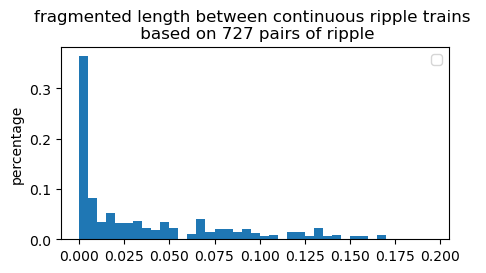

In [258]:
plt.figure(figsize = (5,2.5))
plt.hist(frag_sum_animal, weights = np.ones(len(frag_sum_animal))/len(frag_sum_animal),
         bins = np.arange(0,0.2,0.005))
plt.legend()
plt.ylabel('percentage')
plt.title(f'fragmented length between continuous ripple trains \n based on {len(frag_sum_animal)} pairs of ripple')

727

In [6]:
animal = 'Eliot'
dates_to_plot = ['20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'

In [39]:
animal = 'Lewis'
dates_to_plot = ['20240107','20240108','20240109','20240110','20240116','20240118','20240119','20240120']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

In [42]:
(num_all, 
 num_cont_all, num_frag_all, 
 pct_cont_all, pct_frag_all, 
 time_cont_all, time_frag_all) = cont_vs_frag_occurrence_day(animal,dates_to_plot,
                                                             encoding_set,classifier_param_name,decode_threshold_method)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240107_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240107_ 2         02_Rev2Session pos 1 valid ti
lewis20240107_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240107_ 4         04_Rev2Session pos 3 valid ti
lewis20240107_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240107_ 6         06_Rev2Session pos 5 valid ti
lewis20240107_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240107_ 8         08_Rev2Session pos 7 valid ti
lewis20240107_ 9         09_Rev2Sleep5  pos 8 valid ti
lewis20240107_ 10        10_Rev2Session pos 9 valid ti
lewis20240107_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240108_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240108_ 2         02_Rev2Session pos 1 valid ti
lewis20240108_ 3         03_Rev2Sleep2  pos 2 valid

### plot by session

In [43]:
label = []
for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)
    for ind in range(len(run_session_names)):
        label.append(d[6:9]+'\n'+str(run_session_ids[ind]))

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240107_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240107_ 2         02_Rev2Session pos 1 valid ti
lewis20240107_ 3         03_Rev2Sleep2  pos 2 valid ti
lewis20240107_ 4         04_Rev2Session pos 3 valid ti
lewis20240107_ 5         05_Rev2Sleep3  pos 4 valid ti
lewis20240107_ 6         06_Rev2Session pos 5 valid ti
lewis20240107_ 7         07_Rev2Sleep4  pos 6 valid ti
lewis20240107_ 8         08_Rev2Session pos 7 valid ti
lewis20240107_ 9         09_Rev2Sleep5  pos 8 valid ti
lewis20240107_ 10        10_Rev2Session pos 9 valid ti
lewis20240107_ 11        11_Rev2Sleep6  pos 10 valid t
 (Total: 11)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
lewis20240108_ 1         01_Rev2Sleep1  pos 0 valid ti
lewis20240108_ 2         02_Rev2Session pos 1 valid ti
lewis20240108_ 3         03_Rev2Sleep2  pos 2 valid

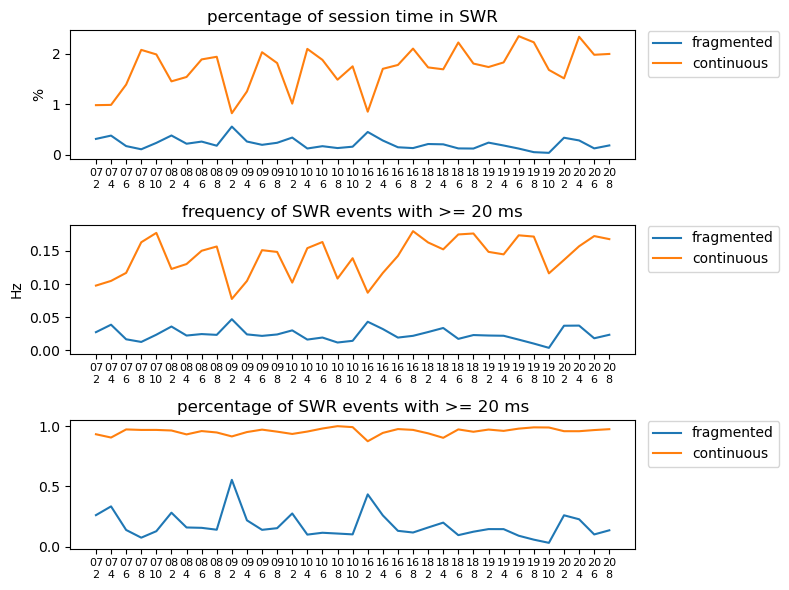

In [44]:
time_cont_plot = np.concatenate([time_cont_all[d] for d in dates_to_plot])
time_frag_plot = np.concatenate([time_frag_all[d] for d in dates_to_plot])

num_cont_plot = np.concatenate([num_cont_all[d] for d in dates_to_plot])
num_frag_plot = np.concatenate([num_frag_all[d] for d in dates_to_plot])

pct_cont_plot = np.concatenate([pct_cont_all[d] for d in dates_to_plot])
pct_frag_plot = np.concatenate([pct_frag_all[d] for d in dates_to_plot])

fig, axes = plt.subplots(3,1, figsize = (8,6))
axes[0].plot(time_frag_plot*100, label = 'fragmented')
axes[0].plot(time_cont_plot*100, label = 'continuous')
axes[0].set_xticks(np.arange(len(label)));
axes[0].set_xticklabels(label,fontsize = 8);
axes[0].set_title('percentage of session time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))

axes[1].plot(num_frag_plot, label = 'fragmented')
axes[1].plot(num_cont_plot, label = 'continuous')
axes[1].set_xticks(np.arange(len(label)));
axes[1].set_xticklabels(label,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))

axes[2].plot(pct_frag_plot, label = 'fragmented')
axes[2].plot(pct_cont_plot, label = 'continuous')
axes[2].set_xticks(np.arange(len(label)));
axes[2].set_xticklabels(label,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))

fig.tight_layout()

### plot by day

In [45]:
time_cont_day = [np.mean(time_cont_all[d]) for d in dates_to_plot]
time_frag_day = [np.mean(time_frag_all[d]) for d in dates_to_plot]

num_cont_day = [np.mean(num_cont_all[d]) for d in dates_to_plot]
num_frag_day = [np.mean(num_frag_all[d]) for d in dates_to_plot]

pct_cont_day = [np.sum(num_cont_all[d])/num_all[d] for d in dates_to_plot]
pct_frag_day = [np.sum(num_frag_all[d])/num_all[d] for d in dates_to_plot]

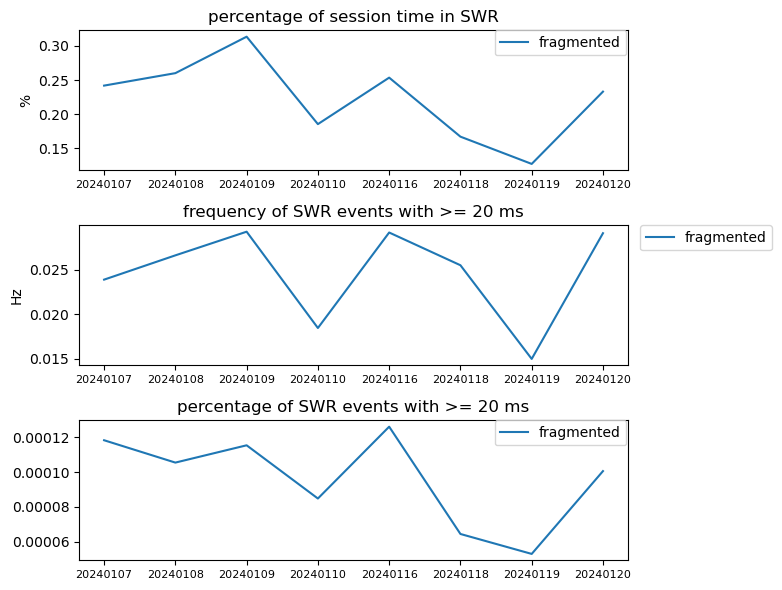

In [46]:
fig, axes = plt.subplots(3,1, figsize = (8,6))
axes[0].plot(np.array(time_frag_day) * 100, label = 'fragmented')
#axes[0].plot(np.array(time_cont_day) * 100, label = 'continuous')
axes[0].set_xticks(np.arange(len(dates_to_plot)));
axes[0].set_xticklabels(dates_to_plot,fontsize = 8);
axes[0].set_title('percentage of session time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))

axes[1].plot(num_frag_day, label = 'fragmented')
#axes[1].plot(num_cont_day, label = 'continuous')
axes[1].set_xticks(np.arange(len(dates_to_plot)));
axes[1].set_xticklabels(dates_to_plot,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))

axes[2].plot(pct_frag_day, label = 'fragmented')
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[2].set_xticks(np.arange(len(dates_to_plot)));
axes[2].set_xticklabels(dates_to_plot,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))

fig.tight_layout()

### Below are the same notebook as (Offline Ripple Analysis) 4. PairwiseBehaviorAndReplay 

In [ ]:
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

count, P_replay_all = replay_transitions(animal,dates_to_plot,encoding_set,classifier_param_name)
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

#### 1. Row normalized (conditional probablity)

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.8, '0.8')]

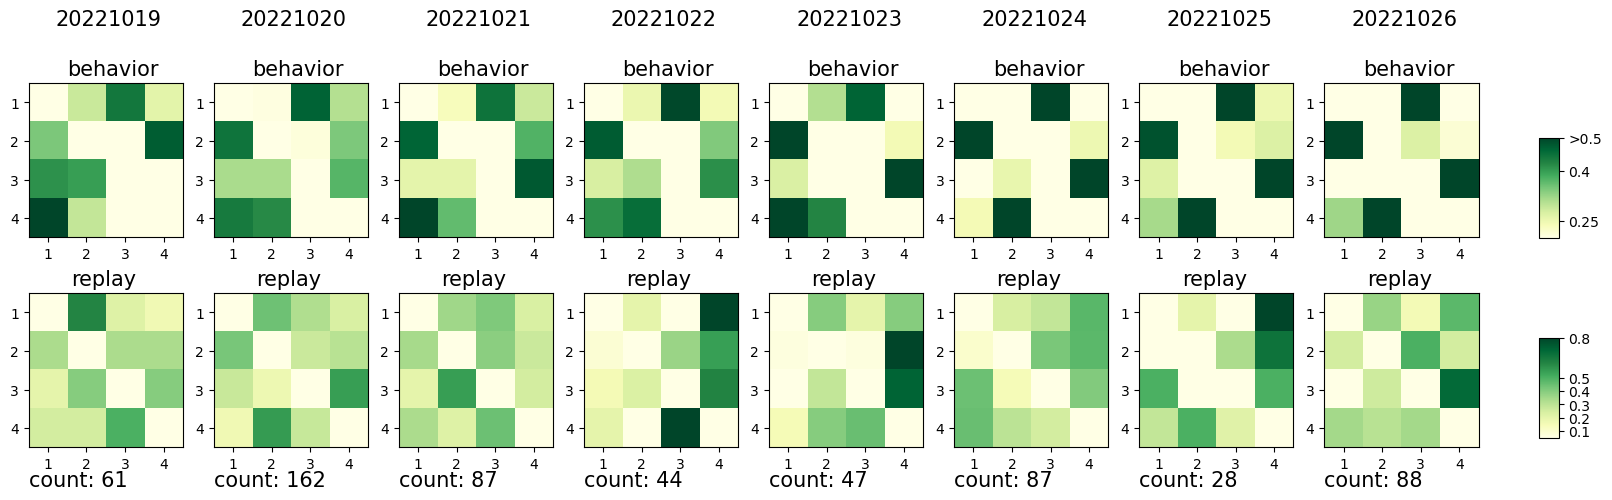

In [305]:
version = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 0.8
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

#### 2. Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

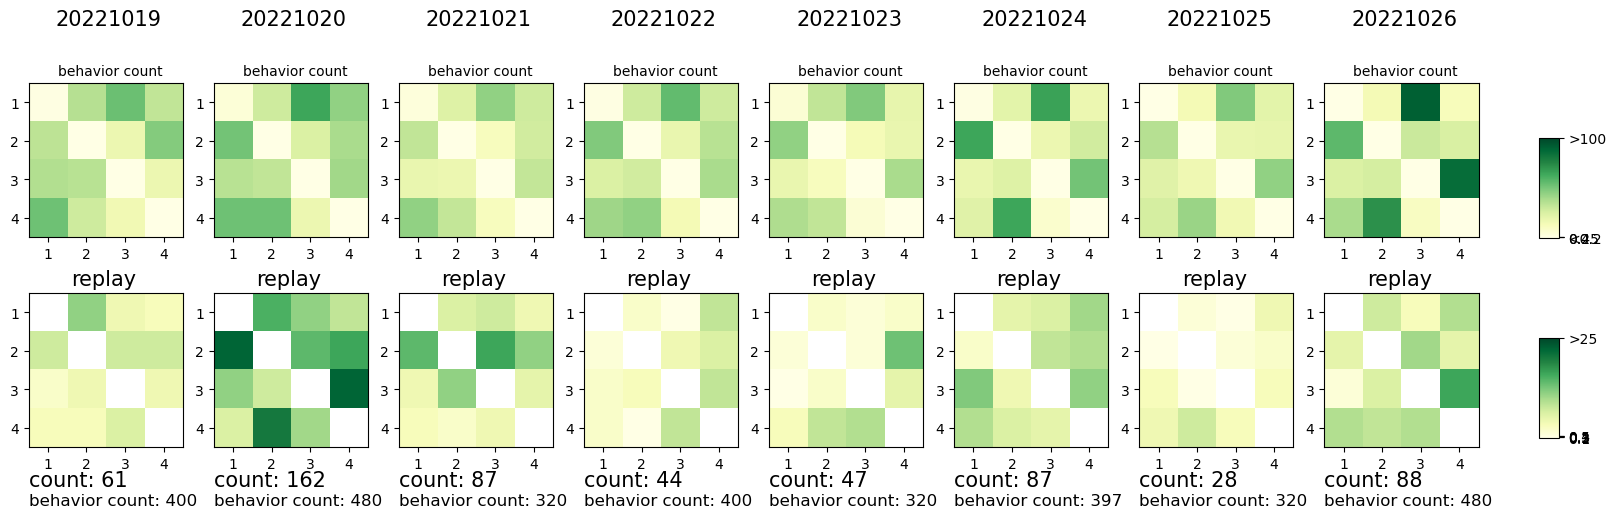

In [411]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.25,-0.7,'behavior count',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 3. Rewarded Transition Behavior Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

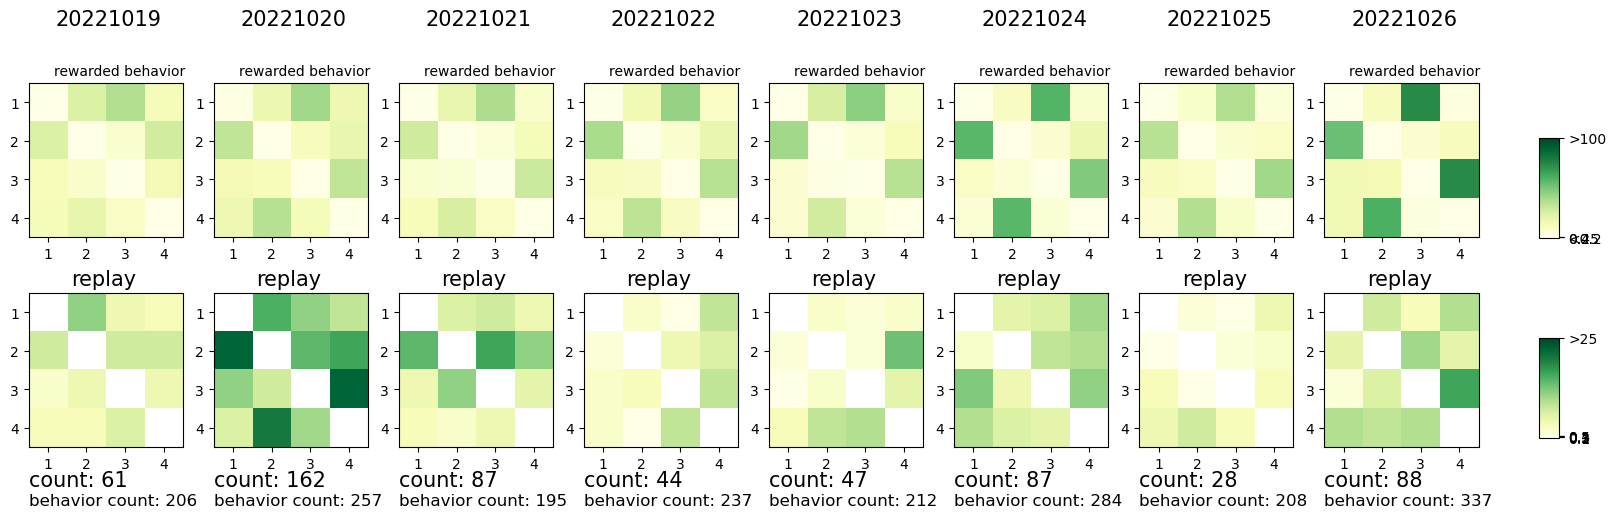

In [441]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_reward_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.15,-0.7,'rewarded behavior',fontsize = 10)


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 4. delta reward

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '>0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.2, '>0.2')]

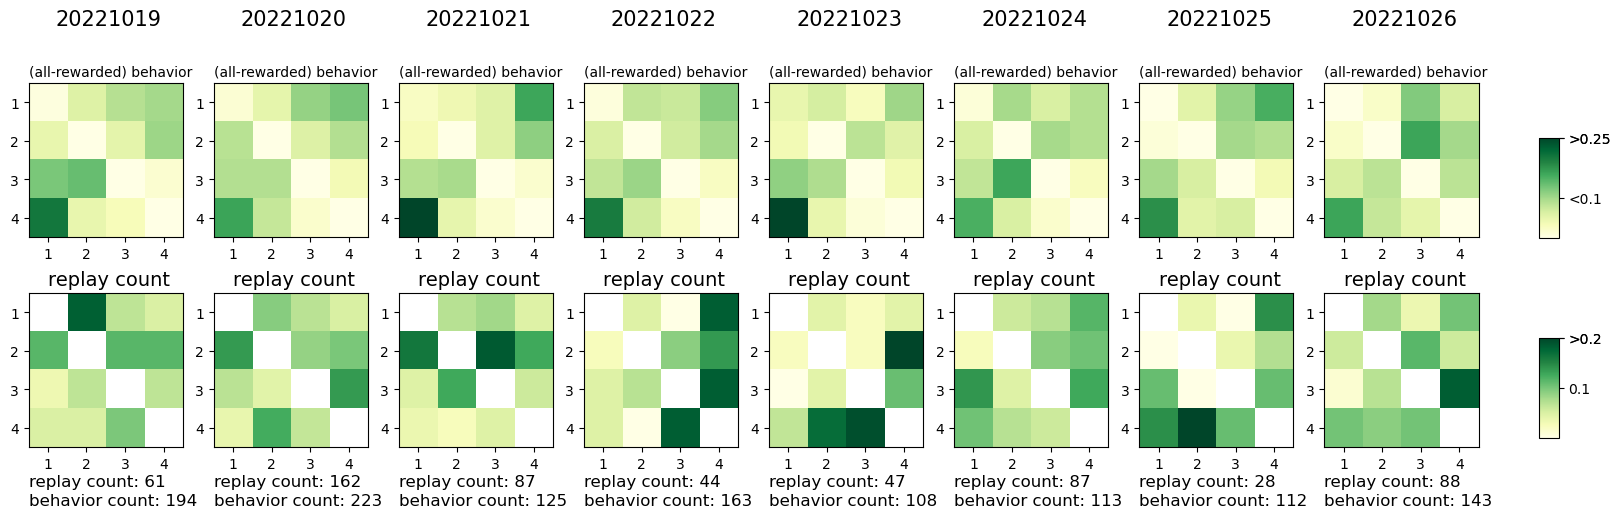

In [440]:
version = 0
normalize = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

if normalize:
    REPLAY_VMAX = 0.2
    BEHAVIOR_VMAX = 0.25
else:
    REPLAY_VMAX = 20
    BEHAVIOR_VMAX = 40 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    d_minus1 = dates_to_plot[d_ind-1]
    behavior_data = (C_behavior_all[d]-C_behavior_reward_all[d])#/np.sum(C_behavior_all[d])
    if normalize:
        behavior_data_plot = behavior_data/np.sum(behavior_data)
        im1 = axes[0,d_ind].imshow(behavior_data_plot, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'replay count: ' + str(int(count[d]))
    if normalize:
        replay_data = replay_data/np.nansum(replay_data)
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0,-0.7,'replay count',fontsize = 14)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(-0.5,-0.7,'(all-rewarded) behavior',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.1', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 5. Trial-by-trial analysis

In [854]:
from spyglass.shijiegu.pairwiseDecode import trial_by_trial_behavior_replay_pairs,trial_by_trial_random_behavior_replay_pairs

LOOK_BACK_NUM = 2
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [ ]:
LOOK_BACK_NUM = 2
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

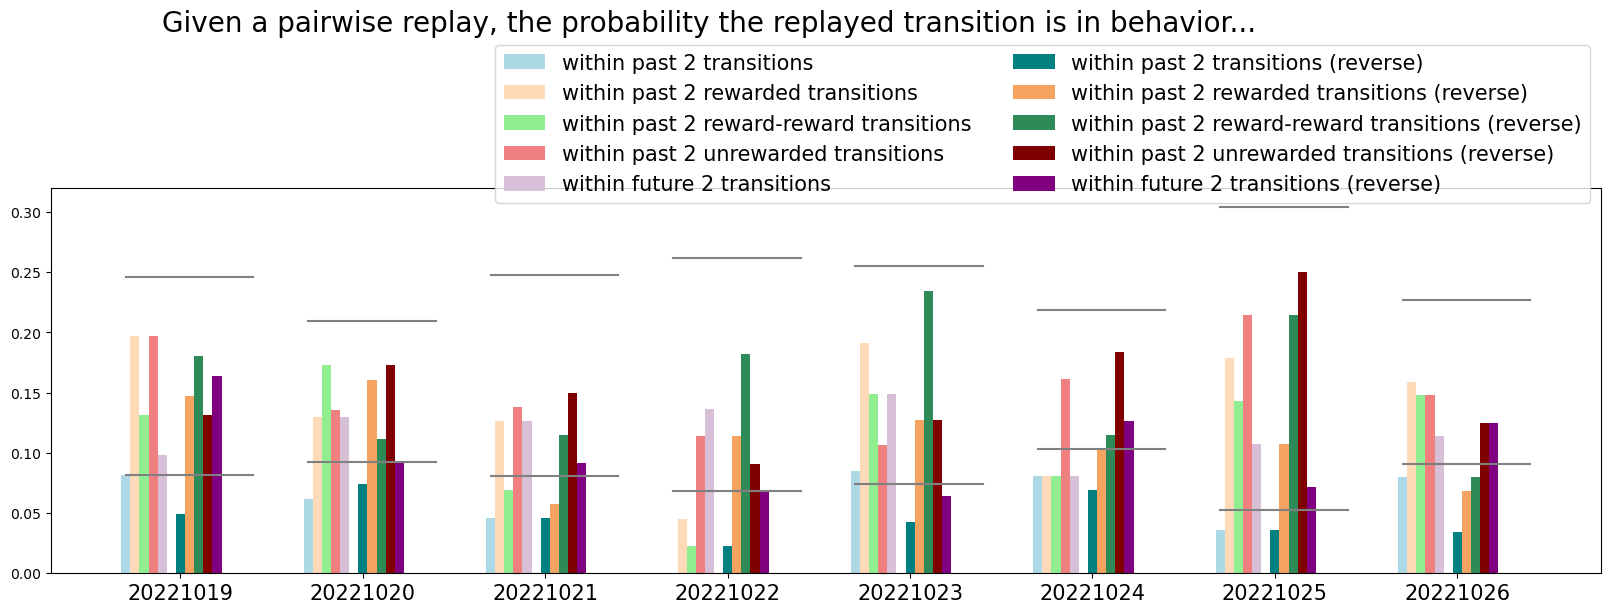

In [868]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.45,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

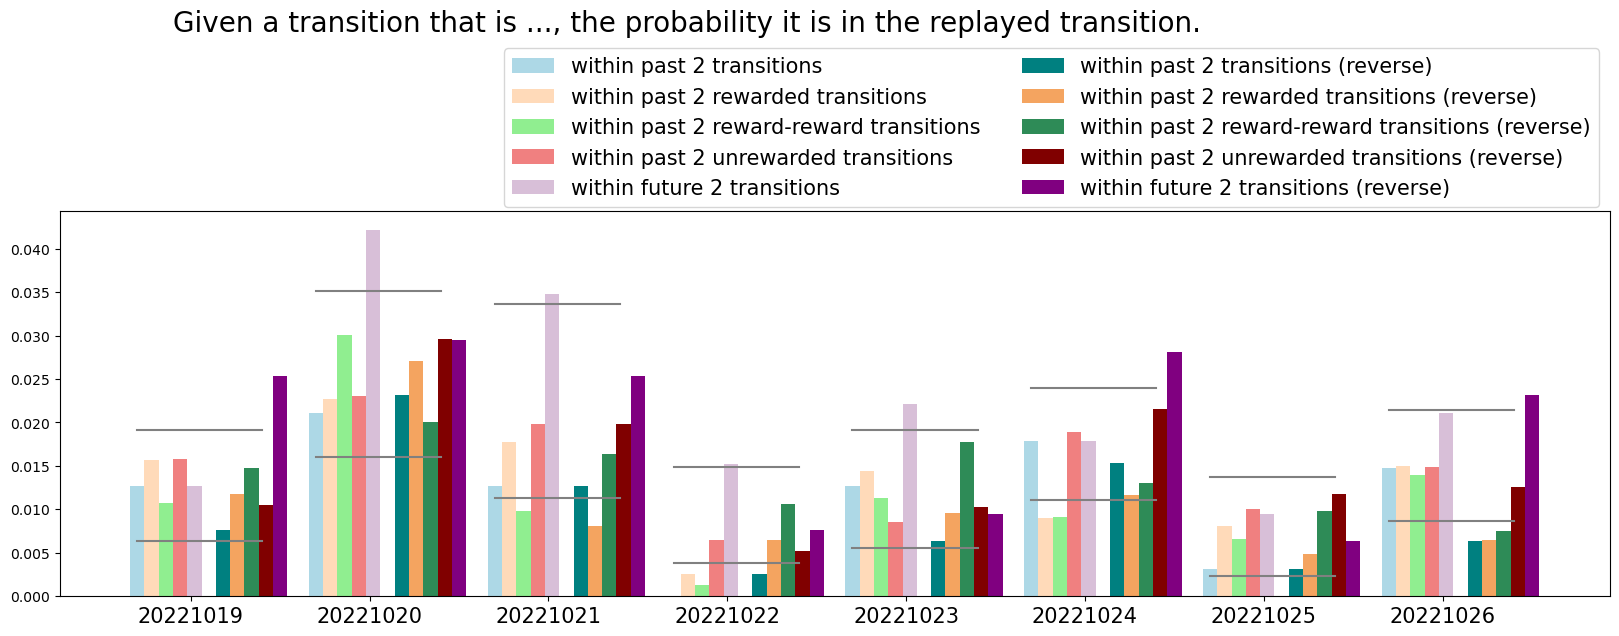

In [875]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.08
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_transition_random_25[d],p_transition_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_transition_random_975[d],p_transition_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.065,'Given a transition that is ..., the probability it is in the replayed transition.',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.45))

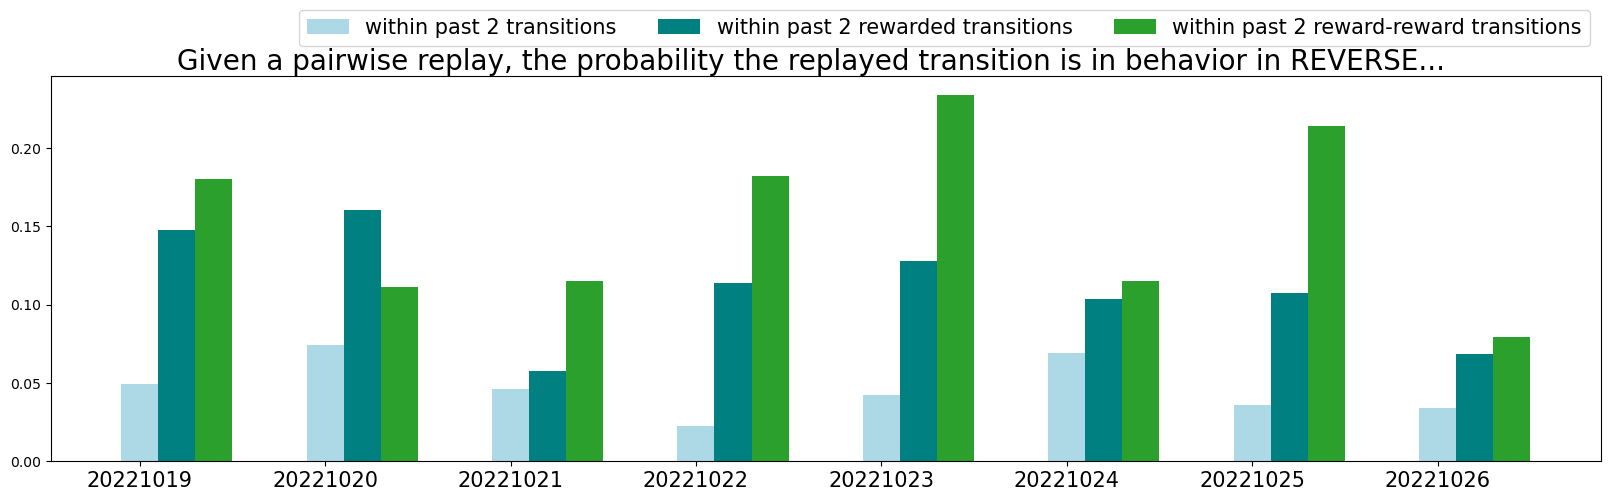

In [683]:
### In the case of just wanting one set
fig,axes = plt.subplots(1,1,figsize = (20,5))
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2)
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2)
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2)
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot)))
axes.set_xticklabels(dates_to_plot,fontsize = 15)
axes.text(0.2,axes.get_ylim()[1] + 0.1,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);

In [878]:
LOOK_BACK_NUM = 1
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [879]:
LOOK_BACK_NUM = 1
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

working on bootstrap iteration: 0
working on bootstrap iteration: 1
working on bootstrap iteration: 2
working on bootstrap iteration: 3
working on bootstrap iteration: 4
working on bootstrap iteration: 5
working on bootstrap iteration: 6
working on bootstrap iteration: 7
working on bootstrap iteration: 8
working on bootstrap iteration: 9
working on bootstrap iteration: 10
working on bootstrap iteration: 11
working on bootstrap iteration: 12
working on bootstrap iteration: 13
working on bootstrap iteration: 14
working on bootstrap iteration: 15
working on bootstrap iteration: 16
working on bootstrap iteration: 17
working on bootstrap iteration: 18
working on bootstrap iteration: 19
working on bootstrap iteration: 20
working on bootstrap iteration: 21
working on bootstrap iteration: 22
working on bootstrap iteration: 23
working on bootstrap iteration: 24
working on bootstrap iteration: 25
working on bootstrap iteration: 26
working on bootstrap iteration: 27
working on bootstrap iteration

In [877]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/pairwiseDecode.py(324)trial_by_trial_behavior_replay_pairs_day()
    322         denominator_transition += denominator_transition_
    323     return (nominator_replay/denominator_replay,denominator_replay,
--> 324             nominator_transition/denominator_transition,denominator_transition)
    325 
    326 



ipdb>  nominator_transition


0


ipdb>  exit


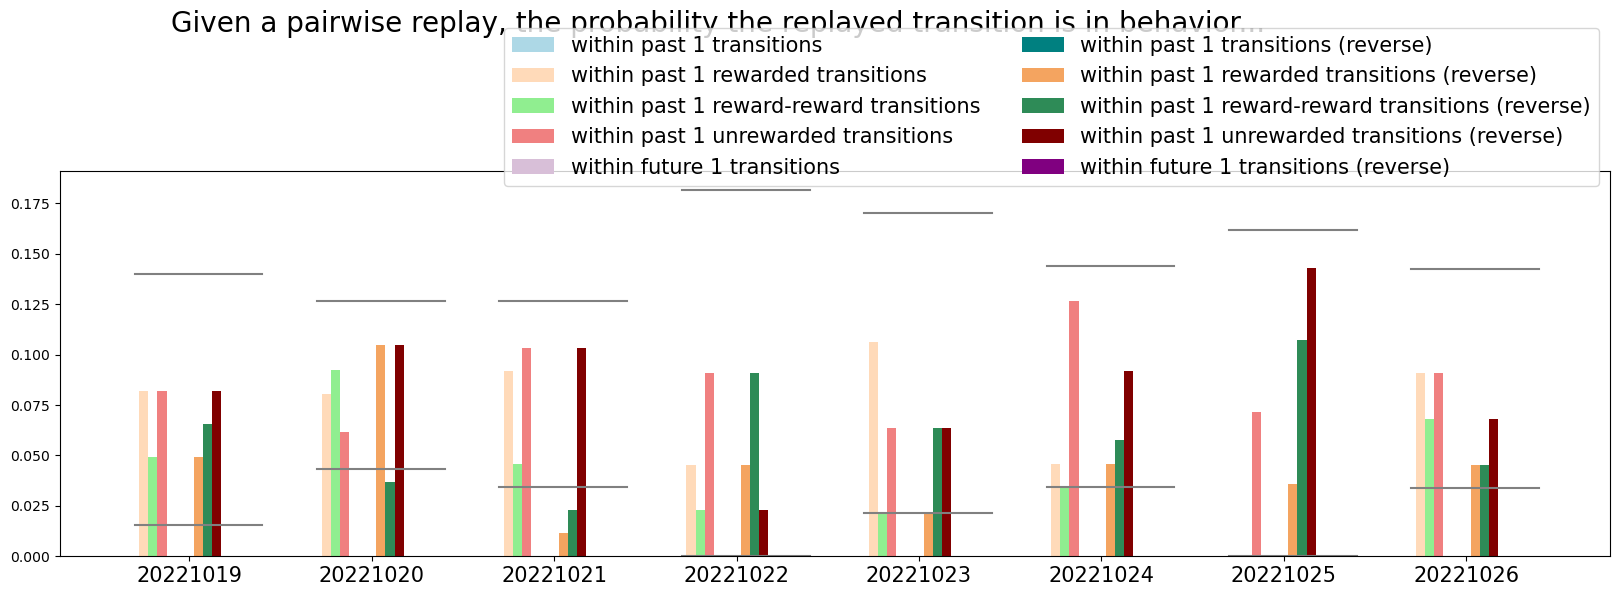

In [885]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)

"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.26,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

### Plot 1b. Find intersection events

In [256]:
key_acausal = {'nwb_file_name': 'eliot20221023_.nwb',
        'interval_list_name': '02_Seq2Session1',
        'classifier_param_name':'default_decoding_gpu_4armMaze',
        'encoding_set':encoding_set}
key_causal = key_acausal.copy()
key_causal['classifier_param_name'] = 'causal_decoding_gpu_4armMaze'

trials_a = pd.DataFrame((TrialChoiceReplayTransition & key_acausal).fetch1('choice_reward_replay_transition'))
trials_c = pd.DataFrame((TrialChoiceReplayTransition & key_causal).fetch1('choice_reward_replay_transition'))

In [274]:
transition_session = np.zeros((4,4))

for t in [60]:#trials_a.index:
    r_a = set(trials_a.loc[t].replayed_transitions)
    r_c = set(trials_c.loc[t].replayed_transitions)
    common_t = r_a.intersection(r_c)
    for ct in common_t:
        i = int(ct[0])-1
        j = int(ct[1])-1
        transition_session[i,j] += 1

In [275]:
common_t

set()

In [261]:
transition_session

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [2., 1., 1., 0.]])

In [121]:
trials_c.loc[18].replayed_transitions

[]

In [133]:
a = set([(2,4),(1,3)])
b = set([(2,4),(1,3)])

In [135]:
c = a.intersection(b)

In [136]:
c

{(1, 3), (2, 4)}

### Plot 2. Correlation with the sequence

In [302]:
version = 2
transition_dict = {}
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    transition_dict[d] = P_replay_all[d][version]
    
xcorr_replay_plot= findXCorrAllDays(transition_dict)

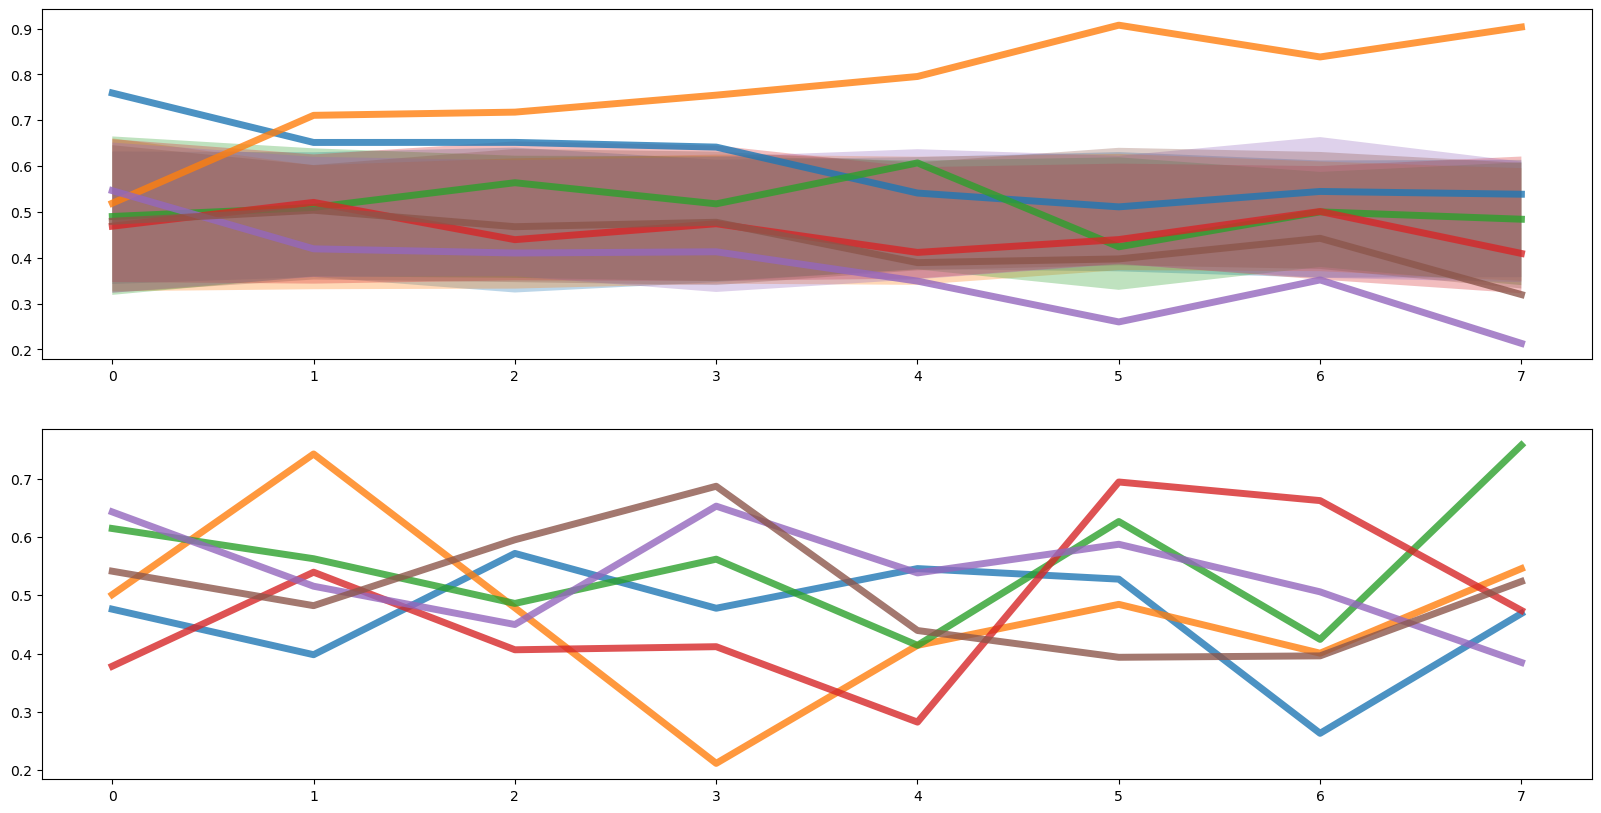

In [303]:
f,axes = plt.subplots(2,1,figsize = (20,10))
for seq_ind in range(6):
    axes[0].plot(xcorr_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)
    axes[0].fill_between(np.arange(len(dates_to_plot)),
                    xcorr25_plot[:,seq_ind],
                    xcorr975_plot[:,seq_ind], facecolor='C'+str(seq_ind), alpha=0.3)

for seq_ind in range(6):
    axes[1].plot(xcorr_replay_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)

### Investigate another session

In [224]:
session_interval

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']

In [48]:
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': '04_Seq2Session2'}
T_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

In [49]:
T_transition_[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,[],"[[[1666467957.1042895, 1666467957.1802895], [1...",[],"[[[4], [4], [2]]]",[],[1],2.0,2.0,4.0,NaN,NaN
2,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,[],"[[[1666467971.4162765, 1666467971.910276]]]",[],[[[4]]],[],[2],4.0,4.0,3.0,2.0,NaN
3,1.666468e+09,1.0,1.666468e+09,3.0,"[(1, 3)]",2.0,"[[[1666467986.9242623, 1666467987.114262], [16...",[],"[[[0, 3], [0]], [[0]], [[1], [3]]]",[],"[3, 4, 5]",[],3.0,3.0,1.0,4.0,NaN
4,1.666468e+09,1.0,1.666468e+09,1.0,[],1.0,"[[[1666468033.5662196, 1666468033.8102193]]]",[],[[[0]]],[],[6],[],1.0,1.0,4.0,3.0,3.0
5,1.666468e+09,1.0,1.666468e+09,4.0,[],2.0,"[[[1666468058.1321971, 1666468058.2501972], [1...","[[[1666468074.1761825, 1666468074.3281825], [1...","[[[0], [2], [], []], [[0], [3], []]]","[[[4], [], []], [[], [0]], [[3, 4]], [[4]]]","[7, 8]","[9, 10, 11, 12]",4.0,4.0,2.0,1.0,3.0
6,1.666468e+09,1.0,1.666468e+09,2.0,[],2.0,"[[[1666468091.9001665, 1666468092.0261662], [1...","[[[1666468100.436159, 1666468100.7301583]], [[...","[[[0], [0]], [[], []]]","[[[2]], [[2, 3], [3], [2]], [[2]], [[2], [2]]]","[13, 14]","[15, 16, 17, 18]",2.0,2.0,3.0,4.0,4.0
7,1.666468e+09,1.0,1.666468e+09,3.0,[],1.0,"[[[1666468129.8861315, 1666468130.0101316], [1...",[],"[[[], [], [], [0]], [[], [0]]]",[],"[19, 20]",[],3.0,3.0,1.0,2.0,2.0
8,1.666468e+09,1.0,1.666468e+09,1.0,[],2.0,"[[[1666468148.7041144, 1666468148.9621143], [1...","[[[1666468162.6301017, 1666468162.7521017], [1...","[[[0, 3], [], [0]]]","[[[], [], [], [0]]]",[21],[22],1.0,1.0,4.0,3.0,2.0
9,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,"[[[1666468180.2980857, 1666468180.5160854], [1...",[],"[[[0], [0]], [[0, 2], [], [0], [], [0]], [[0]]...",[],"[23, 24, 25, 26, 27]",[],4.0,4.0,2.0,1.0,1.0
10,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,"[[[1666468201.668066, 1666468201.784066], [166...",[],"[[[], [], [0]]]",[],[28],[],2.0,2.0,1.0,4.0,1.0


In [227]:
matrix_transition_ 

,0,1,2,3
0,7.0,0.0,0.0,1.0
1,0.0,3.0,0.0,2.0
2,0.0,2.0,7.0,0.0
3,0.0,9.0,2.0,17.0
